In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt


2023-11-06 11:13:24.984438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 11:13:25.014079: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 11:13:25.014105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 11:13:25.014125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 11:13:25.019100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 11:13:25.019774: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def load_dataset(num_samples=100):
    ds_builder = tfds.builder("clic_edm_qq_pf", data_dir='../../../tensorflow_datasets/')
    dss = ds_builder.as_data_source("test")
    limited_dss = []

    for elem in dss:
        limited_dss.append(elem)
        if len(limited_dss) >= num_samples:
            break

    return limited_dss


In [3]:
def warm_up_gpu(dss):
    for elem in dss:
        _ = tf.dtypes.cast(elem["X"], tf.float16)
        break


In [4]:
def quantize_data(dss):
    original_outputs = []
    quantized_outputs = []

    for elem in dss:
        original_output = elem["X"]
        quantized_output = tf.dtypes.cast(original_output, tf.float16)

        original_outputs.extend(tf.reshape(original_output, [-1]))
        quantized_outputs.extend(tf.reshape(quantized_output, [-1]))

    return original_outputs, quantized_outputs


In [5]:
def measure_inference_time(dss):
    total_time = 0
    num_samples = 0

    for elem in dss:
        start_time = time.time()
        quantized_weights = tf.dtypes.cast(elem["X"], tf.float16)
        end_time = time.time()
        total_time += end_time - start_time
        num_samples += 1

        if num_samples >= 10:  # Process 10 samples
            break

    average_inference_time = total_time / num_samples
    print(f'Average Inference Time: {average_inference_time} seconds')

    

In [8]:
def plot_histograms(original_outputs, quantized_outputs, quantization_type):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(original_outputs, bins=100, range=(0, 255), color='blue', alpha=0.7, label='Original')
    plt.title('Histogram Before Quantization')
    plt.xlim(-5,120)
#     plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(quantized_outputs, bins=100, range=(0, 255), color='orange', alpha=0.7, label='Quantized')
    plt.title(f'Histogram After {quantization_type} Quantization')  # Include quantization type in title
    plt.xlim(-5,120)
    #     plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.legend()

    plt.tight_layout()
    plt.show()


Average Inference Time: 0.002369117736816406 seconds


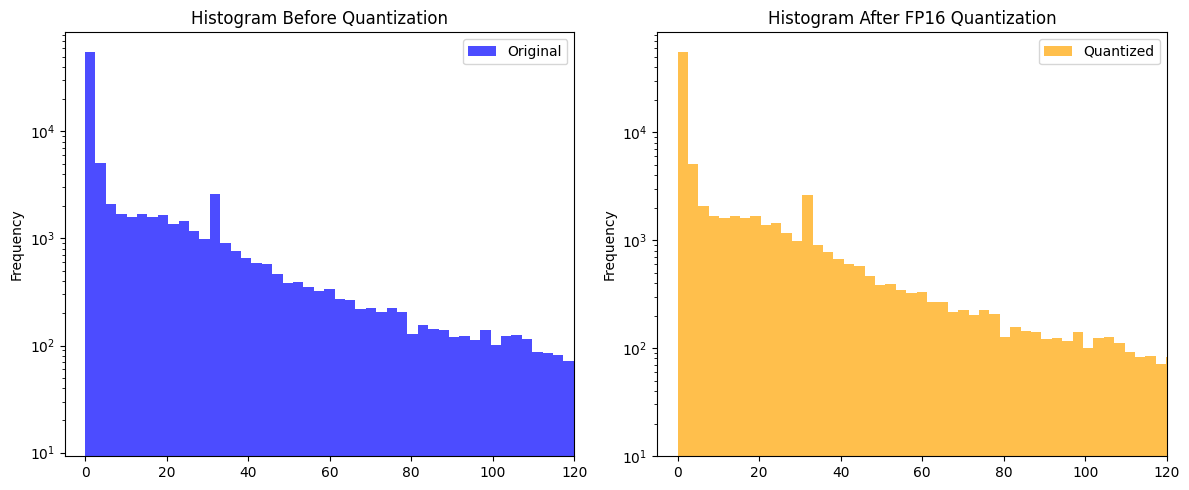

In [9]:
if __name__ == "__main__":
    dss = load_dataset(num_samples=100)
    warm_up_gpu(dss)
    original_outputs, quantized_outputs = quantize_data(dss)
    quantized_outputs = tf.stack(quantized_outputs).numpy()  # Convert to NumPy array
    measure_inference_time(dss)
    plot_histograms(original_outputs, quantized_outputs, 'FP16')


# Int8 Quantization

In [10]:
def quantize_data_int8(dss):
    original_outputs = []
    quantized_outputs = []

    for elem in dss:
        original_output = elem["X"]
        
        # Scale the data to the range [0, 255]
        scaled_output = (original_output - tf.reduce_min(original_output)) / (tf.reduce_max(original_output) - tf.reduce_min(original_output)) * 255
        
        # Quantize to int8
        quantized_output = tf.quantization.quantize(scaled_output, 0, 255, tf.qint8)

        original_outputs.extend(tf.reshape(original_output, [-1]))
        quantized_outputs.extend(tf.reshape(quantized_output[0], [-1]))  # Access the values from the quantized tensor

    return original_outputs, quantized_outputs


Instructions for updating:
`tf.quantize_v2` is deprecated, please use `tf.quantization.quantize` instead.


Instructions for updating:
`tf.quantize_v2` is deprecated, please use `tf.quantization.quantize` instead.


Average Inference Time: 0.0024777650833129883 seconds


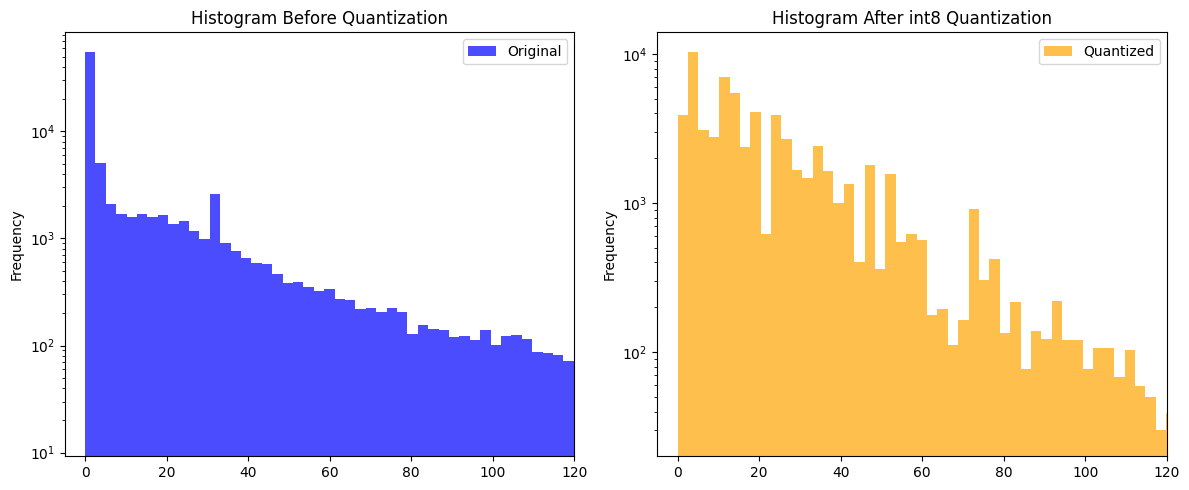

In [11]:
if __name__ == "__main__":
    dss = load_dataset(num_samples=100)
    warm_up_gpu(dss)
    original_outputs, quantized_outputs = quantize_data_int8(dss)  # Use int8 quantization
    quantized_outputs = tf.stack(quantized_outputs).numpy()  # Convert to NumPy array
    measure_inference_time(dss)
    plot_histograms(original_outputs, quantized_outputs, 'int8')
